# Model exploration

  

Prerequirements to run this notebook:
* download all libraries mentioned in `requirements.txt`
* download [filtered ParaNMT-detox corpus dataset](https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip)
* unzip archive via graphical interface (ui.py) or just by hands to a directory `../data/raw/filtered_paranmt/filtered.tsv`

Basic information about the dataset
* `reference` (str) - First item from the pair
* `ref_tox` (float) - toxicity level of reference text
* `translation` (str) - second item from the pair - paraphrazed version of the reference
* `trn_tox` (float) - toxicity level of translation text
* `similarity` (float) - cosine similarity of the texts
* `lenght_diff` (float) - relative length difference between texts

In [1]:
import pandas as pd

df = pd.read_table('../data/raw/filtered_paranmt/filtered.tsv', index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


# Preprocessing step

I will use techniques 1.1-1.3 (from `LearningDataset` notebook) for preprocessing. Main idea is to split translation/reference to toxic/non-toxic columns (as they are mixed) and introduce some threasholds on simmilarity and toxicity.


1.1 During data preprocessing introduce new features `toxic` and `non-toxic` based on `ref_tox` and `trn_tox` scores.\
1.2 Introduce `toxisity_difference` threashold duting preprocessing.\
1.3 Tune which `simmilarity` value to consider in order to save sence of the sentences.

In [2]:
toxisity_difference = 0.75
simmilarity_rate = 0.65

In [3]:
# split words to toxic & non-toxic based on rate [1.1]
tox_queries = []
ntox_queries = []

for tox_query, ntox_query, sim, len_diff, tox, ntox in df.values:
    if tox < ntox:
        tox, ntox = ntox, tox
        tox_query, ntox_query = ntox_query, tox_query 
    
    # add threasholds on toxisity_difference [1.2] and simmilarity rate [1.3]
    if (tox - ntox) >= toxisity_difference and sim >= simmilarity_rate:
        tox_queries.append((tox_query, tox))
        ntox_queries.append((ntox_query, ntox))

print(f'Queries passed: {round(100 * len(tox_queries) / df.shape[0], 2)}%')

# convert processed data to dataframes
tox = pd.DataFrame(tox_queries, columns=['message', 'tox_score'])
non_tox = pd.DataFrame(ntox_queries, columns=['message', 'tox_score'])

tox.head()

Queries passed: 72.61%


,message,tox_score
0,"if Alkar floods her with her mental waste, it ...",0.981983
1,you're becoming disgusting.,0.999039
2,"well, we can spare your life.",0.985068
3,"monkey, you have to wake up.",0.994215
4,I have orders to kill her.,0.999348


In [5]:
import spacy
import torch
from tqdm import tqdm
from collections import Counter
from torchtext.vocab import vocab


# tokenize_fn = spacy.load('en_core_web_sm')


def tokenize_dataset(data: pd.DataFrame, spacy_tokenizer: str = 'en_core_web_sm'):
    tokenize_fn = spacy.load(spacy_tokenizer)
    
    tokenized, tox_scores = [], []
    for message, tox_score in tqdm(data.values):
        tokenized.append([str(token) for token in tokenize_fn(message.lower())])
        tox_scores.append(tox_score)
    
    new_data = pd.DataFrame(columns=['message', 'tox_score'])
    new_data.message = tokenized
    new_data.tox_score = tox_scores
    
    return new_data


def count_words(data: pd.DataFrame) -> Counter:
    data = data.copy()
    
    counter = Counter()

    for tokens in tqdm(data.message):
        for token in tokens:
            counter[token] += 1
    
    return counter

def delete_low_frequency_inplace(counter: Counter, threshold: int = 10):
    import gc
    
    for (elem, freq) in list(counter.items()):
        if freq < threshold:
            del counter[elem]
    
    gc.collect()
    
    return counter

In [6]:
def create_vocab(counter: Counter, print_info: bool = True):
    PAD_TOKEN = "<PAD>"
    UNK_TOKEN = "<UNK>"
    SOS_TOKEN = "<SOS>"
    EOS_TOKEN = "<EOS>"

    SPECIALS = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN]

    tox_vocab = vocab(counter, specials=SPECIALS)

    tox_vocab.set_default_index(tox_vocab[UNK_TOKEN])

    if print_info:
        print("Number of tokens: {}".format(len(tox_vocab)))
    
    return tox_vocab


def save_vocab(vocab, filename: str = None):
    if filename is None:
        filename = f'spacy-processed-vocab-{len(vocab)}.pth'
    torch.save(vocab, filename)
    print(f'Succesfully saved vocab as `{filename}`')


def load_vocab(filename: str):
    return torch.load(filename)

In [7]:
import ast

tokenized_tox = pd.read_csv('tokenized-tox.csv', index_col=0)
tokenized_non_tox = pd.read_csv('tokenized-non-tox.csv', index_col=0)

tokenized_tox.message = tokenized_tox.message.apply(ast.literal_eval)
tokenized_non_tox.message = tokenized_non_tox.message.apply(ast.literal_eval)

In [8]:
whole_dataset = pd.concat([tokenized_tox, tokenized_non_tox])

word_counter = count_words(whole_dataset)

print('Number of unique words:', len(word_counter))
threshold = 40  # 50 works fine with 7121 words!
delete_low_frequency_inplace(word_counter, threshold=threshold)
print('Number of words after removing low frequency:', len(word_counter))

word_vocab = create_vocab(word_counter)
save_vocab(word_vocab, f'full-words-vocab-{threshold}.pth')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 838990/838990 [00:02<00:00, 378257.99it/s]


Number of unique words: 90026
Number of words after removing low frequency: 8243
Number of tokens: 8247
Succesfully saved vocab as `full-words-vocab-40.pth`


In [9]:
from sklearn.model_selection import train_test_split

X = tokenized_tox
y = tokenized_non_tox

# split data to train/test
    dataset_lim = 16000 * 24 # 1 minute is approximately 16k, so let's make epoch approximately 30 minutes *24
X_train, X_test, y_train, y_test = train_test_split(X[:dataset_lim], y[:dataset_lim], test_size=0.1, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


print('Train size:', X_train.shape[0])
print('Test size:', X_test.shape[0])

Train size: 345600
Test size: 38400


In [10]:
vocab = load_vocab(f'full-words-vocab-{threshold}.pth')

In [11]:
from torchtext.vocab.vocab import Vocab


class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 tokenized_tox_data: pd.DataFrame, 
                 tokenized_non_tox_data: pd.DataFrame,
                 vocab: Vocab,
                 max_size: int = 150
                ):
        self.max_size = max_size
        self.tox_data = tokenized_tox_data
        self.non_tox_data = tokenized_non_tox_data
        self.vocab = vocab
    
    def _get_sentence(self, index: int, is_toxic: bool) -> list[int]:
        # retrieves sentence from dataset by index
        if is_toxic:
            sent = ['<SOS>'] + self.tox_data.message[index] + ['<EOS>']
        else:
            sent = ['<SOS>'] + self.non_tox_data.message[index] + ['<EOS>']
        
        if len(sent) <= self.max_size:
            sent.extend(['<PAD>'] * (self.max_size - len(sent)))
        else:
            sent = sent[:self.max_size - 1] + ['<EOS>']
        
        return self.vocab(sent)
    
    def __getitem__(self, index) -> tuple[list[int], list[int]]:
        return self._get_sentence(index, is_toxic=True), self._get_sentence(index, is_toxic=False)
    
    def __len__(self) -> int:
        return self.tox_data.shape[0]

In [12]:
max_size = 75

train_dataset = ToxicDataset(X_train, y_train, vocab, max_size=max_size)
test_dataset = ToxicDataset(X_test, y_test, vocab, max_size=max_size)

In [13]:
batch_size = 128


def collate_batch(batch: list):
    toxic, non_toxic = [], []
    for (tox, non_tox) in batch:
        toxic.append(torch.tensor(tox))
        non_toxic.append(torch.tensor(non_tox))
    return torch.stack(toxic), torch.stack(non_toxic)


train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Model itself 

Code structure was taken from [pytorch seq2seq tutorial](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb) with some modifications


In [14]:
import torch
from torch import nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [15]:
import numpy as np

class DSkBart(nn.Module):
    def __init__(self, vocab_size: int, device: str = 'cpu'):
        super().__init__()
        
        ENC_EMB_DIM = 128
        DEC_EMB_DIM = 128
        ENC_HID_DIM = 256
        DEC_HID_DIM = 256
        ENC_DROPOUT = 0.5
        DEC_DROPOUT = 0.5

        self.attention = Attention(ENC_HID_DIM, DEC_HID_DIM)
        self.encoder = Encoder(vocab_size, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
        self.decoder = Decoder(vocab_size, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, self.attention)
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DSkBart(len(vocab), device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,119,799 trainable parameters


In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

model

DSkBart(
  (attention): Attention(
    (attn): Linear(in_features=768, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (encoder): Encoder(
    (embedding): Embedding(8247, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(8247, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=8247, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [19]:
from torch.optim import Adam

PAD_IDX = vocab['<PAD>']

optimizer = Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    
    epoch_loss = 0
    for i, batch in enumerate(tqdm(iterator)):
        tox, non_tox = batch
        tox, non_tox = tox.to(device), non_tox.to(device)
        tox, non_tox = tox.T, non_tox.T
        
        optimizer.zero_grad()
        output = model(tox, non_tox)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        non_tox = non_tox[1:].flatten()
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, non_tox)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [21]:
def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):
            tox, non_tox = batch
            tox, non_tox = tox.to(device), non_tox.to(device)
            tox, non_tox = tox.T, non_tox.T

            output = model(tox, non_tox, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            non_tox = non_tox[1:].flatten()

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, non_tox)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [22]:
import math

N_EPOCHS = 14
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_dataloader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:29<00:00,  3.33it/s]


Epoch: 01
	Train Loss: 4.306 | Train PPL:  74.171
	 Val. Loss: 4.276 |  Val. PPL:  71.970


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:30<00:00,  3.33it/s]


Epoch: 02
	Train Loss: 3.274 | Train PPL:  26.420
	 Val. Loss: 4.030 |  Val. PPL:  56.261


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:30<00:00,  3.31it/s]


Epoch: 03
	Train Loss: 3.008 | Train PPL:  20.245
	 Val. Loss: 4.036 |  Val. PPL:  56.584


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:31<00:00,  3.28it/s]


Epoch: 04
	Train Loss: 2.883 | Train PPL:  17.863
	 Val. Loss: 3.999 |  Val. PPL:  54.523


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:32<00:00,  3.25it/s]


Epoch: 05
	Train Loss: 2.799 | Train PPL:  16.432
	 Val. Loss: 3.973 |  Val. PPL:  53.158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:32<00:00,  3.25it/s]


Epoch: 06
	Train Loss: 2.741 | Train PPL:  15.508
	 Val. Loss: 3.941 |  Val. PPL:  51.491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:30<00:00,  3.31it/s]


Epoch: 07
	Train Loss: 2.700 | Train PPL:  14.881
	 Val. Loss: 3.926 |  Val. PPL:  50.680


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:29<00:00,  3.34it/s]


Epoch: 08
	Train Loss: 2.661 | Train PPL:  14.311
	 Val. Loss: 3.988 |  Val. PPL:  53.935


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:31<00:00,  3.27it/s]


Epoch: 09
	Train Loss: 2.630 | Train PPL:  13.879
	 Val. Loss: 3.985 |  Val. PPL:  53.799


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:30<00:00,  3.33it/s]


Epoch: 10
	Train Loss: 2.605 | Train PPL:  13.527
	 Val. Loss: 3.929 |  Val. PPL:  50.836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:30<00:00,  3.33it/s]


Epoch: 11
	Train Loss: 2.585 | Train PPL:  13.269
	 Val. Loss: 3.989 |  Val. PPL:  53.987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:33<00:00,  3.22it/s]


Epoch: 12
	Train Loss: 2.562 | Train PPL:  12.960
	 Val. Loss: 4.002 |  Val. PPL:  54.680


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:31<00:00,  3.27it/s]


Epoch: 13
	Train Loss: 2.550 | Train PPL:  12.807
	 Val. Loss: 3.965 |  Val. PPL:  52.712


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:31<00:00,  3.27it/s]

Epoch: 14
	Train Loss: 2.537 | Train PPL:  12.637
	 Val. Loss: 3.992 |  Val. PPL:  54.142


In [23]:
best_model = DSkBart(len(vocab))
best_model.load_state_dict(torch.load('best-model.pt'))

In [151]:
def inference(model, text: pd.DataFrame, vocab, max_size: int, already_tokenized: bool = False):
    tokenized_text = tokenize_dataset(text) if not already_tokenized else text
    text_dataset = ToxicDataset(tokenized_text, tokenized_text, vocab, max_size=max_size)
    text_dataloader = torch.utils.data.DataLoader(dataset=text_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    
    model.eval()
    
    words = []
    
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(text_dataloader)):
            tox, non_tox = batch
            tox, non_tox = tox.to(device), non_tox.to(device)
            tox, non_tox = tox.T, non_tox.T

            output = model(tox, non_tox, 0) #turn off teacher forcing
            
            words.extend(output.argmax(dim=2).T.cpu().detach().tolist())
    
    return words

In [152]:
text_df = pd.DataFrame(columns=['message', 'tox_score'])
text_df.message = ['I hate you, bitch', 'i love you', "Now you're getting nasty", 'This is dumb']
text_df.tox_score = 0.5


text_df

,message,tox_score
0,"I hate you, bitch",0.5
1,i love you,0.5
2,Now you're getting nasty,0.5
3,This is dumb,0.5


In [153]:
text_vocab_ids = inference(best_model, text_df, vocab, max_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


In [154]:
def from_vocab(text: list[list[int]], vocab):
    for line in text:
        yield vocab.lookup_tokens(line)

In [155]:
print(*[' '.join(words) for words in from_vocab(text_vocab_ids, vocab)], sep='\n\n')

<PAD> i hate you , <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

<PAD> i love you love <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

<PAD> now you 're getting ugly . <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> 

In [156]:
# import all required libraries for validation
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# initialize tokenizer and model from s-nlp/detox repository
toxic_model_name = 'SkolkovoInstitute/roberta_toxicity_classifier'

toxic_tokenizer = RobertaTokenizer.from_pretrained(toxic_model_name)
toxic_model = RobertaForSequenceClassification.from_pretrained(toxic_model_name)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [162]:
from tqdm import tqdm

# define batch size and join words in messages
# batch_size = 64
answers = []
scores = []

X_test.message = X_test.message.apply(lambda words: list(map(str, words)))

for i in tqdm([0, 1, 2]): # tqdm(range(int(np.ceil(X_test.shape[0] /  batch_size)))):
    X_test_subsample = X_test[i * batch_size:(i + 1) * batch_size]
    X_test_subsample = X_test_subsample.reset_index(drop=True)
    
    test_vocab_inds = inference(best_model, X_test_subsample, vocab, max_size, already_tokenized=True)
    answers.extend([' '.join(words) for words in from_vocab(test_vocab_inds, vocab)])


for i in tqdm([0, 1, 2]): # tqdm(range(int(np.ceil(X_test.shape[0] / batch_size)))):
    batch = answers[i * batch_size:(i + 1) * batch_size]

    # run sample batch from tokenizer & model (and calculate results)
    tokens = toxic_tokenizer(text=batch, return_tensors='pt', padding=True)
    
    with torch.inference_mode():
        logits = toxic_model(**tokens).logits
    scores.extend(list(torch.softmax(logits, -1)[:, 1].cpu().numpy()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:34<00:00, 31.34s/it]


(array([366.,   2.,   3.,   1.,   2.,   0.,   4.,   0.,   2.,   4.]),
 array([4.68782091e-05, 9.89068598e-02, 1.97766840e-01, 2.96626806e-01,
        3.95486802e-01, 4.94346768e-01, 5.93206763e-01, 6.92066729e-01,
        7.90926695e-01, 8.89786720e-01, 9.88646686e-01]),
 <BarContainer object of 10 artists>)

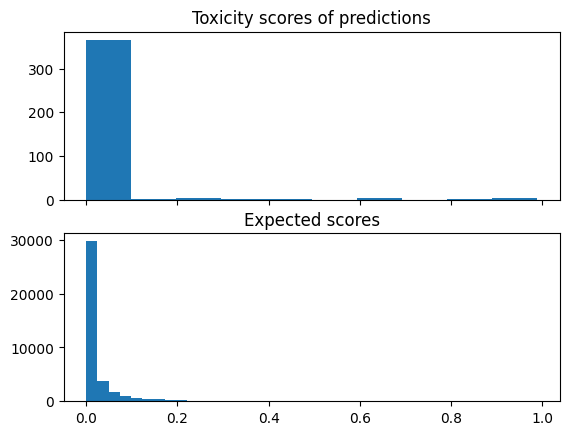

In [163]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True)

axs[1].set_title('Expected scores')
axs[1].hist(y_test.tox_score)

axs[0].set_title('Toxicity scores of predictions')
axs[0].hist(scores)

In [164]:
scores = np.array(scores)


def print_stats(arr, start: str = "", round_lim: int = 4):
    mean = round(float(arr.mean()), round_lim)
    std = round(float(arr.std()), round_lim)
    print(start + f"{mean} {std}")


print('Type \t/ mean / std')
print_stats(X_test.tox_score, 'Initial:  ')
print_stats(scores, 'Resulted: ')
print_stats(y_test.tox_score, 'Expected: ')

Type 	/ mean / std
Initial:  0.9668 0.0484
Resulted: 0.0341 0.138
Expected: 0.0204 0.0391
